In [10]:
import sys
import os
sys.path.append(os.path.abspath("../../"))  # or "../../" depending on location
from setup import add_project_root
add_project_root()

In [11]:
import torch
import torch.nn as nn
import scipy.io
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from models.forward.FNO_models import FNO, FNO_noGrad
import matplotlib.pyplot as plt

# データ読み込み
train_data = torch.load('../../data/datasets/data/darcy_train_16.pt')
test_data_16 = torch.load('../../data/datasets/data/darcy_test_16.pt')
test_data_32 = torch.load('../../data/datasets/data/darcy_test_32.pt')
print(train_data.keys())

dict_keys(['x', 'y'])


In [12]:
x = train_data["x"]
y = train_data["y"]
print("x shape:", x.shape)
print("y shape:", y.shape)

x shape: torch.Size([1000, 16, 16])
y shape: torch.Size([1000, 16, 16])


In [13]:
x_train, y_train = train_data['x'], train_data['y']
x_test, y_test = test_data_16['x'], test_data_16['y']
x_train = x_train.unsqueeze(-1) 
x_test = x_test.unsqueeze(-1)
y_train = y_train.unsqueeze(-1)  # (B, H, W) → (B, H, W, 1)
y_test = y_test.unsqueeze(-1)


In [14]:
print("x_train shape:", x_train.shape)  


x_train shape: torch.Size([1000, 16, 16, 1])


In [ ]:
batch_size = 16

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# データを全部 CUDA に転送

x_train = x_train.float().to(device)
y_train = y_train.float().to(device)
x_test = x_test.float().to(device)
y_test = y_test.float().to(device)

train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

# --- モデル定義 ---
model = FNO(modes1=8, modes2=8, width=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# --- 早期終了設定 ---
best_val_loss = float('inf')
patience = 10
wait = 0

train_losses = []
val_losses = []

# --- 学習ループ ---
for epoch in range(1000):
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        
        pred = model(xb)
        loss = criterion(pred, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * xb.size(0)

    train_loss /= len(train_loader.dataset)

    # --- 検証 ---
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            
            pred = model(xb)
            loss = criterion(pred, yb)
            val_loss += loss.item() * xb.size(0)
    val_loss /= len(val_loader.dataset)

    print(f"Epoch {epoch}: Train Loss = {train_loss:.4e}, Val Loss = {val_loss:.4e}")
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    # --- 早期終了判定 ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        wait = 0
        # 保存処理（必要に応じてコメントアウト外す）
        torch.save(model.state_dict(), "../../results/forward/checkpoints/best_darcy_fno_model.pth")
    else:
        wait += 1
        if wait >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

RuntimeError: einsum(): subscript y has size 16 for operand 1 which does not broadcast with previously seen size 9

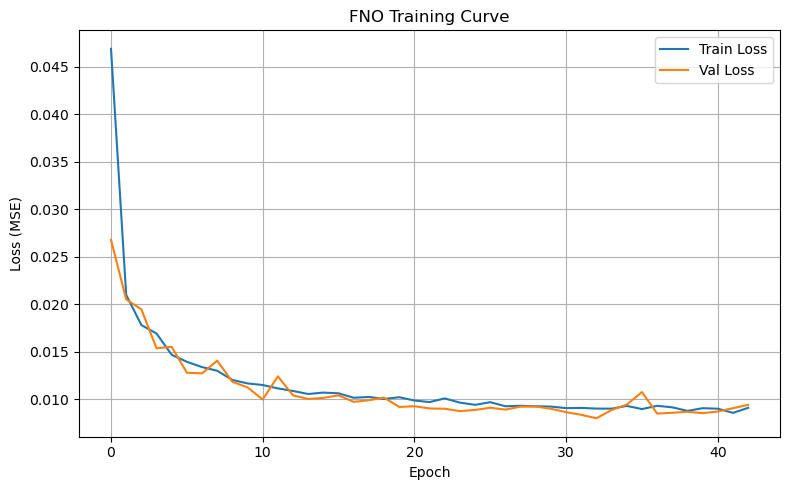

In [ ]:
#学習曲線の可視化

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("FNO Training Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


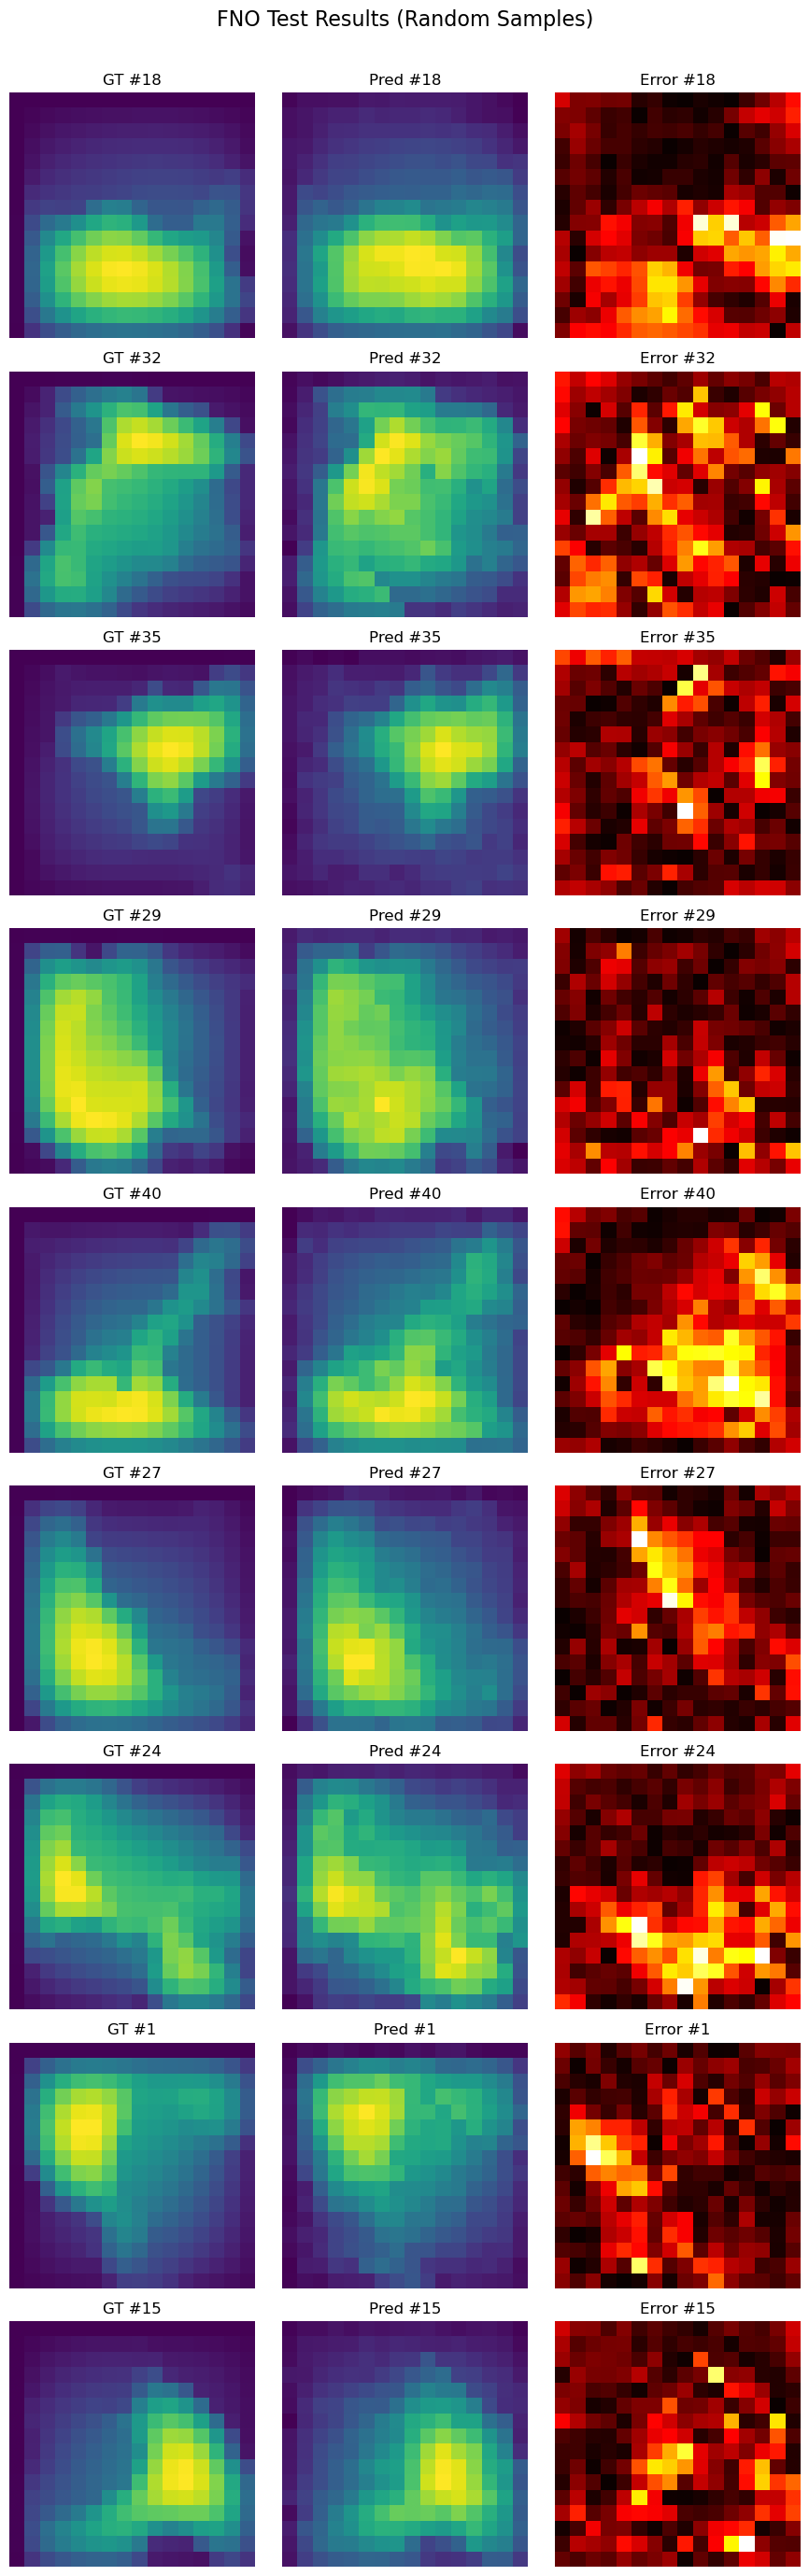

In [ ]:
model.eval()
with torch.no_grad():
    pred_test = model(x_test)

# NumPy化
p = pred_test.cpu().numpy()
y = y_test.cpu().numpy()

# ランダムに表示数選ぶ（例：9枚）
num_samples = 9
indices = np.random.choice(len(y), size=num_samples, replace=False)

# 可視化
fig, axs = plt.subplots(num_samples, 3, figsize=(9, 3 * num_samples))

for i, idx in enumerate(indices):
    gt = y[idx, :, :, 0]
    pred = p[idx, :, :, 0]
    err = np.abs(gt - pred)

    axs[i, 0].imshow(gt, cmap='viridis')
    axs[i, 0].set_title(f"GT #{idx}")
    axs[i, 0].axis('off')

    axs[i, 1].imshow(pred, cmap='viridis')
    axs[i, 1].set_title(f"Pred #{idx}")
    axs[i, 1].axis('off')

    axs[i, 2].imshow(err, cmap='hot')
    axs[i, 2].set_title(f"Error #{idx}")
    axs[i, 2].axis('off')

plt.tight_layout()
plt.suptitle("FNO Test Results (Random Samples)", fontsize=16, y=1.02)
plt.show()
